In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
sys.path.append("../../")

In [3]:
import os
import gc
import time
from self_control.utils import get_suffix_grads_from_wrapped_model
# os.environ["CUDA_VISIBLE_DEVICES"]="6"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from itertools import islice
import torch
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from self_control.suffix_gradient import WrappedReadingVecModel
import torch.nn.functional as F
from peft import AdaptionPromptConfig, get_peft_model, LoraModel, LoraConfig

2024-07-14 20:01:58.276051: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 20:01:58.363880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 20:01:59.668710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
model_name_or_path = "meta-llama/Llama-2-7b-chat-hf"
# model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.2"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="cuda:6")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side='left')
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

In [16]:
mistral_adapter_dict = {
    "surprised": "../adapters/calm2surprised-final-mistralprefix+adapter-50-0.003/adapter_model.safetensors",
    "reasoning": "../adapters/reasoning-smallernorm-final-gogogoprefix+adapter-50-0.003/adapter_model.safetensors"
}
llama_adapter_dict = {
    "afraid": "../adapters/afraid2fearless-finalprefix+adapter-50-0.003/adapter_model.safetensors",
    "angry": "../adapters/angry2peaceful-finalprefix+adapter-50-0.003/adapter_model.safetensors",
}

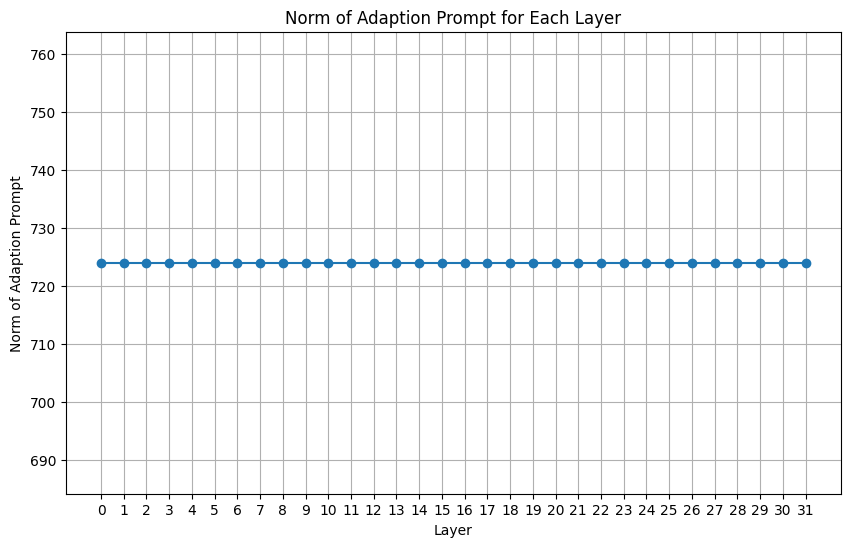

In [17]:
import torch
import matplotlib.pyplot as plt
from safetensors import safe_open

# Path to your SafeTensor file
safetensor_file = llama_adapter_dict["angry"]

# Load the SafeTensor file
with safe_open(safetensor_file, framework="pt") as f:  # Use 'pt' for PyTorch, 'tf' for TensorFlow
    tensors = {key: f.get_tensor(key) for key in f.keys()}

# Extract and calculate norms for each layer
layer_names = []
norms = []

for key, tensor in tensors.items():
    if 'adaption_prompt' in key:
        layer_name = key.split('.')[4]  # Assuming the layer number is at this position
        norm = torch.norm(tensor).item()
        layer_names.append(layer_name)
        norms.append(norm)

# Sort layers by their numerical order
layer_names, norms = zip(*sorted(zip(layer_names, norms), key=lambda x: int(x[0])))

# Plot the norms
plt.figure(figsize=(10, 6))
plt.plot(layer_names, norms, marker='o')
plt.xlabel('Layer')
plt.ylabel('Norm of Adaption Prompt')
plt.title('Norm of Adaption Prompt for Each Layer')
plt.grid(True)
plt.show()
